In [2]:
import dowhy
from dowhy import CausalModel
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression

In [39]:
data = pd.read_csv("https://raw.githubusercontent.com/AMLab-Amsterdam/CEVAE/master/datasets/IHDP/csv/ihdp_npci_1.csv", header = None)
org_data = data
col =  ["treatment", "y_factual", "y_cfactual", "mu0", "mu1" ,]
for i in range(1,26):
    col.append("x"+str(i))
data.columns = col
data = data.astype({"treatment":'bool'}, copy=False)
data.head()

,treatment,y_factual,y_cfactual,mu0,mu1,x1,x2,x3,x4,x5,...,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25
0,True,5.599916,4.318780,3.268256,6.854457,-0.528603,-0.343455,1.128554,0.161703,-0.316603,...,1,1,1,1,0,0,0,0,0,0
1,False,6.875856,7.856495,6.636059,7.562718,-1.736945,-1.802002,0.383828,2.244320,-0.629189,...,1,1,1,1,0,0,0,0,0,0
2,False,2.996273,6.633952,1.570536,6.121617,-0.807451,-0.202946,-0.360898,-0.879606,0.808706,...,1,0,1,1,0,0,0,0,0,0
3,False,1.366206,5.697239,1.244738,5.889125,0.390083,0.596582,-1.850350,-0.879606,-0.004017,...,1,0,1,1,0,0,0,0,0,0
4,False,1.963538,6.202582,1.685048,6.191994,-1.045229,-0.602710,0.011465,0.161703,0.683672,...,1,1,1,1,0,0,0,0,0,0


## Propensity Score Stratification

It divides the dataset into strata (bins) based on propensity scores, ensuring treatment and control groups within each stratum are comparable. 

$$
Stratification\ Weights (Strata\ 'n') = \frac{Number\ of\ element\ in\ strata\ 'n'}{Total\ number\ of\ elements} 
$$
$
Treatment\ effect = (ATE\ of\ each\ strata).(Weights\ associated\ to\ each\ strata) 
$
$
where, . = Dot\ product
$

In [40]:
class PropensityScoreEstimator:
    def __init__(self, treatment_column, outcome_column, confounders_columns):
        self.treatment_col = treatment_column
        self.outcome_col = outcome_column
        self.confounder_cols = confounders_columns
        self.model = LogisticRegression()
        self.propensity_scores = None

    def fit(self, data):
        X = data[self.confounder_cols]
        # treatment
        T = data[self.treatment_col]

        self.model.fit(X, T)
        self.propensity_scores = self.model.predict_proba(X)[:, 1]
        data['propensity_score'] = self.propensity_scores

        return data

    def match(self, data):
        """
        Matching based on propensity scores
        """
        treated = data[data[self.treatment_col]==1]
        print(f'Treated shape: {treated.shape}')
        control = data[data[self.treatment_col]==0]
        print(f'Control shape: {control.shape}')
        matched_control = []
        for _, treated_row in treated.iterrows():
            # taking control row with closest propensity score to treated row
            control_row = control.loc[(control['propensity_score'] - treated_row['propensity_score']).abs().idxmin()]
            matched_control.append(control_row)

        matched_control = pd.DataFrame(matched_control)
        matched_data = pd.concat([treated, matched_control])
        return matched_data

    def estimate_effect(self, data):
        treated = data[data[self.treatment_col]==1]
        control = data[data[self.treatment_col]==0]

        treated_mean = treated[self.outcome_col].mean()
        control_mean = control[self.outcome_col].mean()
        return treated_mean - control_mean

    def stratify(self, data, n_strata=5):
        # divide the dataset into n parts almost equally
        data['stratum'] = pd.qcut(data['propensity_score'], q=n_strata, labels=False)

        treatment_effects = []
        weights = []

        for stratum in range(n_strata):
            stratum_data = data[data['stratum']==stratum]
            treated = stratum_data[stratum_data[self.treatment_col] == 1]
            control = stratum_data[stratum_data[self.treatment_col] == 0]

            if treated.empty or control.empty:
                continue 

            treated_mean = treated[self.outcome_col].mean()
            control_mean = control[self.outcome_col].mean()

            treatment_effect = treated_mean - control_mean 
            treatment_effects.append(treatment_effect)
            weights.append(len(stratum_data)/len(data))

        print(treatment_effects)
        print(weights)

        # weighted average treatment effect
        weights = np.array(weights)
        overall_effect = np.dot(weights, treatment_effects)
        return overall_effect 

In [41]:
estimator = PropensityScoreEstimator(treatment_column='treatment', outcome_column='y_factual', confounders_columns=["x"+str(i) for  i in range(1,26)])
estimator

In [42]:
df = estimator.fit(data)
df.head()

,treatment,y_factual,y_cfactual,mu0,mu1,x1,x2,x3,x4,x5,...,x17,x18,x19,x20,x21,x22,x23,x24,x25,propensity_score
0,True,5.599916,4.318780,3.268256,6.854457,-0.528603,-0.343455,1.128554,0.161703,-0.316603,...,1,1,1,0,0,0,0,0,0,0.283505
1,False,6.875856,7.856495,6.636059,7.562718,-1.736945,-1.802002,0.383828,2.244320,-0.629189,...,1,1,1,0,0,0,0,0,0,0.068051
2,False,2.996273,6.633952,1.570536,6.121617,-0.807451,-0.202946,-0.360898,-0.879606,0.808706,...,0,1,1,0,0,0,0,0,0,0.107717
3,False,1.366206,5.697239,1.244738,5.889125,0.390083,0.596582,-1.850350,-0.879606,-0.004017,...,0,1,1,0,0,0,0,0,0,0.129523
4,False,1.963538,6.202582,1.685048,6.191994,-1.045229,-0.602710,0.011465,0.161703,0.683672,...,1,1,1,0,0,0,0,0,0,0.092541


In [43]:
effect_stratification = estimator.stratify(df)
effect_stratification 

[4.111720436173342, 4.3677116625044565, 4.053667877374529, 4.035469062740869, 3.6475109532226586]
[0.20080321285140562, 0.1994645247657296, 0.1994645247657296, 0.1994645247657296, 0.20080321285140562]


### Using dowhy library!

In [44]:
model=CausalModel(
        data = data,
        treatment='treatment',
        outcome='y_factual',
        common_causes=["x"+str(i) for  i in range(1,26)]
        )

In [45]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True, method_name="maximal-adjustment")

estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification"
)

print("Causal Estimate with Propensity Score Stratification (Using dowhy) is " + str(estimate.value))
print("Causal Estimate with Propensity Score Stratification (From scratch) is " + str(effect_stratification))

Causal Estimate with Propensity Score Stratification (Using dowhy) is 3.9340924323593565
Causal Estimate with Propensity Score Stratification (From scratch) is 4.042777978848405


### Thus, we obtain causal effect of treatment on outcome to be `around 4` with dowhy and scratch, both with propensity score stratification method. 

## Propensity Score Weighting

Once we have the propensity scores, we assign weights to each observation based on how well it matches others in the opposite group. This ensures that groups are comparable, reducing biases.

Propensity scores need to be transformed so they can be used as weights in a linear regression.

$
For\ treatment\ group: w_t = \frac{1}{propensity\ score} 
$
$
For\ control\ group:\ w_c =\ \frac{1}{1-propensity\ score}
$  

In [55]:
class PropensityScoreEstimator2:
    def __init__(self, treatment_column, outcome_column, confounders_columns):
        self.treatment_col = treatment_column
        self.outcome_col = outcome_column
        self.confounder_cols = confounders_columns
        self.model = LogisticRegression()
        self.propensity_scores = None

    def fit(self, data):
        X = data[self.confounder_cols]
        # treatment
        T = data[self.treatment_col]

        self.model.fit(X, T)
        self.propensity_scores = self.model.predict_proba(X)[:, 1]
        data['propensity_score'] = self.propensity_scores

        return data

    def weighting(self, data):
        data['weights'] = np.where(
            data[self.treatment_col]==1,
            1/data['propensity_score'],
            1/(1-data['propensity_score'])
        )
        return data

    def weighting_estimate(self, data):
        data['weights'] = np.where(
            data[self.treatment_col]==1,
            1/data['propensity_score'],
            1/(1-data['propensity_score'])
        )

        treated = data[data[self.treatment_col] == 1]
        control = data[data[self.treatment_col] == 0]

        treated_mean = np.average(treated[self.outcome_col], weights=treated['weights'])
        control_mean = np.average(control[self.outcome_col], weights=control['weights'])
        print(f'Treated mean is: {treated_mean}')
        print(f'Without weights, treated mean is : {np.average(treated[self.outcome_col])}')
        
        print(f'Control mean is: {control_mean}')
        print(f'Without weights, control mean is : {np.average(control[self.outcome_col])}')
        treatment_effect = treated_mean - control_mean
        
        return treatment_effect

In [56]:
estimator2 = PropensityScoreEstimator2(treatment_column='treatment', outcome_column='y_factual', confounders_columns=["x"+str(i) for  i in range(1,26)])
estimator2

In [57]:
df2 = estimator2.fit(org_data)
df2.head()

,treatment,y_factual,y_cfactual,mu0,mu1,x1,x2,x3,x4,x5,...,x18,x19,x20,x21,x22,x23,x24,x25,propensity_score,weights
0,1,5.599916,4.318780,3.268256,6.854457,-0.528603,-0.343455,1.128554,0.161703,-0.316603,...,1,1,0,0,0,0,0,0,0.283505,3.527272
1,0,6.875856,7.856495,6.636059,7.562718,-1.736945,-1.802002,0.383828,2.244320,-0.629189,...,1,1,0,0,0,0,0,0,0.068051,1.073020
2,0,2.996273,6.633952,1.570536,6.121617,-0.807451,-0.202946,-0.360898,-0.879606,0.808706,...,1,1,0,0,0,0,0,0,0.107717,1.120720
3,0,1.366206,5.697239,1.244738,5.889125,0.390083,0.596582,-1.850350,-0.879606,-0.004017,...,1,1,0,0,0,0,0,0,0.129523,1.148795
4,0,1.963538,6.202582,1.685048,6.191994,-1.045229,-0.602710,0.011465,0.161703,0.683672,...,1,1,0,0,0,0,0,0,0.092541,1.101979


In [58]:
weighted_data = estimator2.weighting(df2)
weighted_data.head()

,treatment,y_factual,y_cfactual,mu0,mu1,x1,x2,x3,x4,x5,...,x18,x19,x20,x21,x22,x23,x24,x25,propensity_score,weights
0,1,5.599916,4.318780,3.268256,6.854457,-0.528603,-0.343455,1.128554,0.161703,-0.316603,...,1,1,0,0,0,0,0,0,0.283505,3.527272
1,0,6.875856,7.856495,6.636059,7.562718,-1.736945,-1.802002,0.383828,2.244320,-0.629189,...,1,1,0,0,0,0,0,0,0.068051,1.073020
2,0,2.996273,6.633952,1.570536,6.121617,-0.807451,-0.202946,-0.360898,-0.879606,0.808706,...,1,1,0,0,0,0,0,0,0.107717,1.120720
3,0,1.366206,5.697239,1.244738,5.889125,0.390083,0.596582,-1.850350,-0.879606,-0.004017,...,1,1,0,0,0,0,0,0,0.129523,1.148795
4,0,1.963538,6.202582,1.685048,6.191994,-1.045229,-0.602710,0.011465,0.161703,0.683672,...,1,1,0,0,0,0,0,0,0.092541,1.101979


#### Visualization of weights

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt 

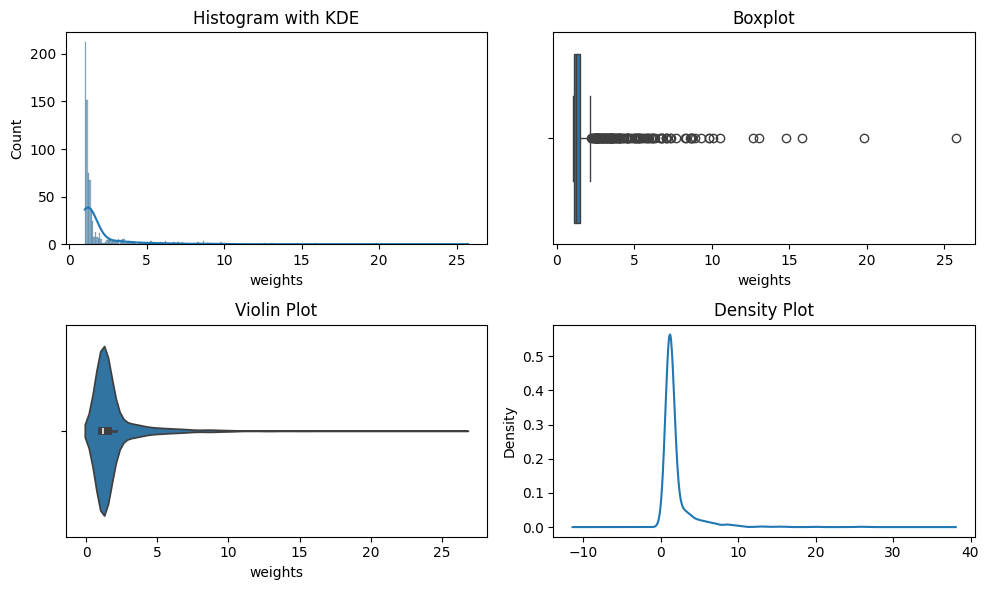

In [60]:
# Set up the plot style
plt.figure(figsize=(10, 6))

# Create multiple visualizations
plt.subplot(2, 2, 1)
sns.histplot(weighted_data['weights'], kde=True)
plt.title('Histogram with KDE')

plt.subplot(2, 2, 2)
sns.boxplot(x=weighted_data['weights'])
plt.title('Boxplot')

plt.subplot(2, 2, 3)
sns.violinplot(x=weighted_data['weights'])
plt.title('Violin Plot')

plt.subplot(2, 2, 4)
weighted_data['weights'].plot(kind='density')
plt.title('Density Plot')

plt.tight_layout()
plt.show()

#### Visualization of weights without outlier weights

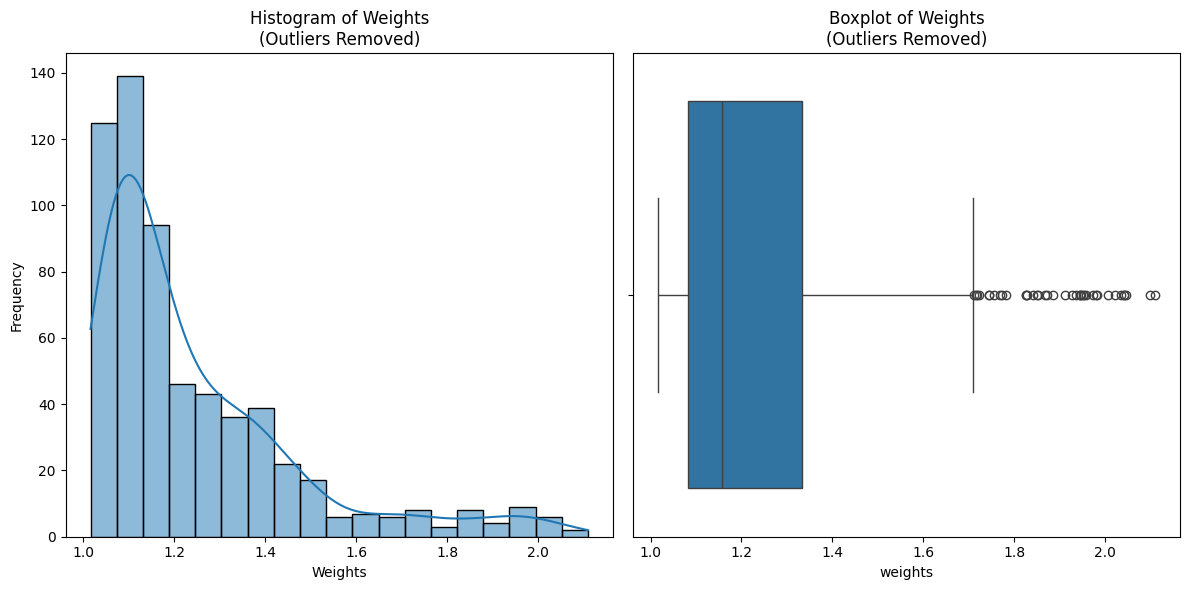

In [61]:
# visualizing with handling of outliers weights 
Q1 = weighted_data['weights'].quantile(0.25)
Q3 = weighted_data['weights'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter outliers
df_filtered = weighted_data[(weighted_data['weights'] >= lower_bound) & (weighted_data['weights'] <= upper_bound)]

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(df_filtered['weights'], kde=True)
plt.title('Histogram of Weights\n(Outliers Removed)')
plt.xlabel('Weights')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.boxplot(x=df_filtered['weights'])
plt.title('Boxplot of Weights\n(Outliers Removed)')

plt.tight_layout()
plt.show()

#### Estimated effect with propensity score weighting

In [62]:
estimated_effect_ps_weighting = estimator2.weighting_estimate(data)
estimated_effect_ps_weighting

Treated mean is: 6.464786901052175
Without weights, treated mean is : 6.432417812422448
Control mean is: 2.4388601384726685
Without weights, control mean is : 2.4112967999916193


In [63]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True, method_name="maximal-adjustment")

estimate_weighting = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_weighting"
)

print("Causal Estimate with Propensity Score Weighting (Using dowhy) is " + str(estimate_weighting.value))
print("Causal Estimate with Propensity Score Weighting (From scratch) is " + str(estimated_effect_ps_weighting))

Causal Estimate with Propensity Score Weighting (Using dowhy) is 4.028653382811937
Causal Estimate with Propensity Score Weighting (From scratch) is 4.025926762579507


### Thus, we obtain causal effect of treatment on outcome to be `4.02` with dowhy and scratch, both with propensity score weighting method. 